In [1]:
from scipy.io import loadmat
import torch
from matplotlib import pyplot as plt
from vae import VanillaVAE
from vae import BetaSchedulerCyclic
from vae import BetaSchedulerMono
import torchvision
from tqdm import tqdm
import os
import time
from torchvision.utils import save_image
from itertools import islice


In [2]:
z_size = 20
in_channels = 1
vae = VanillaVAE(in_channels=in_channels, latent_dim=z_size, res=32, layer_count=2, layer_mult=64)
vae.cuda()
vae.train()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=8192, out_features=20, bias=True)
  (fc_var): Linear(in_features=8192, out_features=20, bias=True)
  (decoder_input): Linear(in_features=20, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=

In [3]:
slen = 32

batch_size_train = 64
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
print (len (train_loader), len (test_loader))

938 40


In [5]:
examples = list(test_loader)
print (examples[0][0].shape)
print (examples[0][1].shape)
print (examples[0][0][0].shape)

# plt.imshow (examples[0][0][0].view(slen,slen))
# plt.colorbar()
# plt.show()
# print (torch.mean(examples[0][0][0]))

torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([1, 32, 32])


In [6]:
results = vae.encoder(examples[0][0][0].view(1,1,slen,slen).cuda())

In [7]:
results[0].shape

torch.Size([128, 8, 8])

In [8]:
name='test'+'_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
print (name)

test_mnist_12-04-2020_03-04-42


In [9]:
a = BetaSchedulerCyclic()

In [10]:
next(a)

0.0

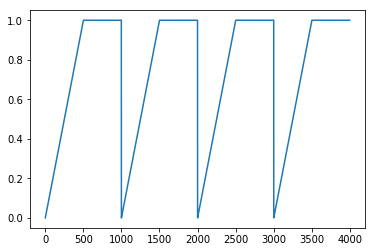

In [11]:
a = BetaSchedulerCyclic()

x = list(islice(a, 0, 4000))
plt.plot(x)
plt.show()

In [14]:
x[999]

1.0000000000000007

In [20]:
name='test_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
os.makedirs(name, exist_ok=True)
recon_dir = os.path.join (name,'results_recon')
os.makedirs(recon_dir, exist_ok=True)
gen_dir = os.path.join (name,'results_gen')
os.makedirs(gen_dir, exist_ok=True)

lr = 0.0005
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 50

re_loss_arr = []
kl_loss_arr = []

# for decode testing, batch size of 64
sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()
beta_iter = BetaSchedulerCyclic(stop=.01, period=1000)

for epoch in tqdm(range(train_epoch)):
    
    re_loss = 0
    kl_loss = 0
    
    for x in train_loader:
        x = x[0].cuda()
        vae.zero_grad()
#         print (x.shape)
        recon, mu, logvar = vae(x)
#         print (recon.shape)
        loss = vae.loss_function(recon, x, mu, logvar, kld_weight=next(beta_iter))
        loss_re, loss_kl = loss['reconstruction_loss'], loss['KLD']
        (loss_re + loss_kl).backward()
        vae_optimizer.step()
        re_loss += loss_re.item()
        kl_loss += loss_kl.item()

    re_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    print('\n[%d/%d] recon loss: %.9f, KL loss: %.9f' % (
        (epoch + 1), train_epoch, re_loss, kl_loss))
    re_loss_arr.append(re_loss)
    kl_loss_arr.append(kl_loss)
    if epoch % 2 == 0:
        with torch.no_grad():
            vae.eval()
            x_rec, _, _ = vae(x)
            resultsample = torch.cat([x, x_rec]) * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen*2, slen),
                       recon_dir + '/' + str(epoch) + '.png')
            x_rec = vae.decode(sample1)
            resultsample = x_rec * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen, slen),
                       gen_dir + '/' + str(epoch) + '.png')
        vae.train()
        
    # checkpoint
    torch.save(vae.state_dict(), name + "/VAEmodel.pkl")
    
print("Training finish!... save training results")
torch.save(vae.state_dict(), "VAEmodel.pkl")
        

  2%|▏         | 1/50 [00:19<15:40, 19.20s/it]


[1/50] recon loss: 0.347272961, KL loss: 0.064410582


  4%|▍         | 2/50 [00:38<15:19, 19.16s/it]


[2/50] recon loss: 0.339975725, KL loss: 0.066747763


  6%|▌         | 3/50 [00:57<14:59, 19.14s/it]


[3/50] recon loss: 0.337528661, KL loss: 0.067636181


  8%|▊         | 4/50 [01:16<14:38, 19.09s/it]


[4/50] recon loss: 0.336456797, KL loss: 0.068148709


 10%|█         | 5/50 [01:35<14:17, 19.05s/it]


[5/50] recon loss: 0.335236727, KL loss: 0.068458082


 12%|█▏        | 6/50 [01:54<13:57, 19.04s/it]


[6/50] recon loss: 0.334383281, KL loss: 0.068690153


 14%|█▍        | 7/50 [02:13<13:38, 19.04s/it]


[7/50] recon loss: 0.333935552, KL loss: 0.068865423


 16%|█▌        | 8/50 [02:32<13:19, 19.04s/it]


[8/50] recon loss: 0.333413041, KL loss: 0.068897342


 18%|█▊        | 9/50 [02:51<13:01, 19.06s/it]


[9/50] recon loss: 0.333233986, KL loss: 0.069227624


 20%|██        | 10/50 [03:10<12:43, 19.10s/it]


[10/50] recon loss: 0.333371849, KL loss: 0.069477389


 22%|██▏       | 11/50 [03:29<12:24, 19.08s/it]


[11/50] recon loss: 0.333632488, KL loss: 0.070031875


 24%|██▍       | 12/50 [03:48<12:04, 19.06s/it]


[12/50] recon loss: 0.333809565, KL loss: 0.070604240


 26%|██▌       | 13/50 [04:07<11:44, 19.05s/it]


[13/50] recon loss: 0.334014587, KL loss: 0.071268696


 28%|██▊       | 14/50 [04:26<11:25, 19.05s/it]


[14/50] recon loss: 0.334214857, KL loss: 0.071925986


 30%|███       | 15/50 [04:45<11:07, 19.06s/it]


[15/50] recon loss: 0.334504481, KL loss: 0.072937590


 32%|███▏      | 16/50 [05:04<10:47, 19.06s/it]


[16/50] recon loss: 0.333867803, KL loss: 0.073739567


 34%|███▍      | 17/50 [05:24<10:29, 19.06s/it]


[17/50] recon loss: 0.331081839, KL loss: 0.069495545


 36%|███▌      | 18/50 [05:43<10:10, 19.07s/it]


[18/50] recon loss: 0.330855158, KL loss: 0.069576296


 38%|███▊      | 19/50 [06:02<09:51, 19.07s/it]


[19/50] recon loss: 0.330885841, KL loss: 0.069487767


 40%|████      | 20/50 [06:21<09:32, 19.09s/it]


[20/50] recon loss: 0.330612915, KL loss: 0.069457117


 42%|████▏     | 21/50 [06:40<09:13, 19.10s/it]


[21/50] recon loss: 0.330521840, KL loss: 0.069516058


 44%|████▍     | 22/50 [06:59<08:54, 19.10s/it]


[22/50] recon loss: 0.330507280, KL loss: 0.069581194


 46%|████▌     | 23/50 [07:18<08:36, 19.12s/it]


[23/50] recon loss: 0.330280078, KL loss: 0.069469945


 48%|████▊     | 24/50 [07:37<08:18, 19.16s/it]


[24/50] recon loss: 0.330146532, KL loss: 0.069514856


 50%|█████     | 25/50 [07:56<07:57, 19.11s/it]


[25/50] recon loss: 0.330437376, KL loss: 0.069699426


 52%|█████▏    | 26/50 [08:16<07:38, 19.11s/it]


[26/50] recon loss: 0.330871437, KL loss: 0.070080785


 54%|█████▍    | 27/50 [08:35<07:19, 19.09s/it]


[27/50] recon loss: 0.331338074, KL loss: 0.070398421


 56%|█████▌    | 28/50 [08:54<07:01, 19.15s/it]


[28/50] recon loss: 0.331655885, KL loss: 0.070985985


 56%|█████▌    | 28/50 [09:05<07:08, 19.49s/it]


KeyboardInterrupt: 

# kl loss with mean, constant kl_weight = .1


[1/50] recon loss: 0.325829175, KL loss: 0.057964935

[2/50] recon loss: 0.296284202, KL loss: 0.048939405

[3/50] recon loss: 0.292565582, KL loss: 0.046701496

[4/50] recon loss: 0.290728960, KL loss: 0.045412801


# kl loss with sum, constant kl_weight = .1


[1/50] recon loss: 0.606855381, KL loss: 0.090462280

[2/50] recon loss: 0.593248408, KL loss: 0.017188402

[3/50] recon loss: 0.591825014, KL loss: 0.010229738

[4/50] recon loss: 0.591900916, KL loss: 0.007903290

[5/50] recon loss: 0.591713661, KL loss: 0.006736573


# ISOnet

In [1]:
from ISONet.isonet.models import *

ModuleNotFoundError: No module named 'isonet'